In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path  # More modern way to handle paths
import warnings # to suppress warnings during plotting

In [2]:
# --- Helper Functions ---
def load_kilosort_data(kilosort_dir):
    """Loads essential data from a Kilosort output directory."""
    data = {}
    try:
        kilosort_dir = Path(kilosort_dir) # Ensure it's a Path object
        
        # Load required files
        data['spike_times'] = np.load(kilosort_dir / 'spike_times.npy').flatten()
        data['spike_clusters'] = np.load(kilosort_dir / 'spike_clusters.npy').flatten()
        # Load optional files
        try:
            data['amplitudes'] = np.load(kilosort_dir / 'amplitudes.npy').flatten()
        except FileNotFoundError:
            data['amplitudes'] = None
            print(f"  Optional file not found: {kilosort_dir / 'amplitudes.npy'}")
        # --- Load Sampling Rate from params.py ---
        # This is a bit basic; robust parsing might be needed if params.py is complex
        sample_rate = None
        params_file = kilosort_dir / 'params.py'
        if params_file.exists():
            with open(params_file, 'r') as f:
                for line in f:
                    if line.strip().startswith('sample_rate') or line.strip().startswith('fs'):
                        try:
                            # Extract the value after '='
                            sample_rate = float(line.split('=')[1].strip().split('#')[0].strip()) # Handle comments
                            break
                        except Exception as e:
                            print(f"  Warning: Could not parse sample_rate from {params_file}: {e}")
            if sample_rate is None:
                 print(f"  Warning: sample_rate not found in {params_file}. Using default 30000.")
                 sample_rate = 30000 # Default fallback
        else:
            print(f"  Warning: params.py not found in {kilosort_dir}. Using default sample rate 30000.")
            sample_rate = 30000 # Default fallback
        data['sample_rate'] = sample_rate
        # --- Load Cluster Info (Quality) ---
        cluster_info_file = kilosort_dir / 'cluster_group.tsv'
        if cluster_info_file.exists():
            try:
                cluster_info = pd.read_csv(cluster_info_file, sep='\t')
                # Prioritize 'group' column, fall back to 'KSLabel'
                if 'group' in cluster_info.columns:
                    quality_col = 'group'
                elif 'KSLabel' in cluster_info.columns:
                     quality_col = 'KSLabel'
                else:
                     quality_col = None
                     
                if quality_col:
                    # Ensure cluster_id column is present and correctly named
                    if 'cluster_id' in cluster_info.columns:
                        id_col = 'cluster_id'
                    elif 'id' in cluster_info.columns:
                         id_col = 'id' # Phy sometimes uses 'id'
                    else:
                         print(f"  Warning: Could not find 'cluster_id' or 'id' column in {cluster_info_file}")
                         id_col = None
                         
                    if id_col:
                         data['cluster_info'] = cluster_info[[id_col, quality_col]].rename(
                            columns={id_col: 'cluster_id', quality_col: 'quality'})
                    else:
                         data['cluster_info'] = None
                         
                else:
                     print(f"  Warning: Could not find 'group' or 'KSLabel' column in {cluster_info_file}")
                     data['cluster_info'] = None
            except Exception as e:
                 print(f"  Warning: Could not read or parse {cluster_info_file}: {e}")
                 data['cluster_info'] = None
        
        else:
            # print(f"  Optional file not found: {cluster_info_file}")
            data['cluster_info'] = None
        
        return data
    except FileNotFoundError as e:
        print(f"  Error loading Kilosort data", end="") #: {e}
        return None
    except Exception as e:
        print(f"  An unexpected error occurred loading data from {kilosort_dir}: {e}")
        return None

In [80]:
# Define the root directory containing your weekly data folders
DATA_ROOT = Path("/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/NEST/ST2036/ST2036E")
# FIGURE_DIR = DATA_ROOT / "figures"
FIGURE_DIR = Path("/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/ehefti/ST2036/ST2036E/figures")

# List the week identifiers (folder names) you want to analyze
WEEKS = ["240628", "240705", "240712", "240718", "240726", "240801", "240809", "240816", "240823"] # "240628", "240705", "240712", "240718", "240726", "240801", "240809", "240816", "240823"

# Choose the plate and the scan
PLATE = "T002736"
SCAN = "Network"

# Define the mapping from well numbers to conditions
CONDITIONS = ["WT", "R133C", "WT + AAV", "R133C + AAV"]
def get_condition(well_index):
    """Assigns condition based on well index (0-23)."""
    if 0 <= well_index <= 2 or 6 <= well_index <= 8:
        return CONDITIONS[0]
    elif 3 <= well_index <= 5 or 9 <= well_index <= 11:
        return CONDITIONS[1]
    elif 12 <= well_index <= 14 or 18 <= well_index <= 20:
        return CONDITIONS[2]
    elif 15 <= well_index <= 17 or 21 <= well_index <= 23:
        return CONDITIONS[3]
    else:
        return "Unknown"
# 4. Define the base name of the Kilosort output folder within each well folder
# If Kilosort output is directly in the well folder, set this to ""
KILOSORT_OUTPUT_DIR_NAME = "sorter_output"
# 5. Quality filtering: Set to None to disable, or a list of acceptable quality labels
# Requires 'cluster_info.tsv' with a 'group' or 'KSLabel' column.
QUALITY_FILTER = ['good'] # Choose between ['good'], ['mua'] or ['good', 'mua'] or set to None to include all

## Data Loading

In [51]:
# --- Main Data Loading and Processing ---
all_data = []
print("Starting data loading process...")
for i, week in enumerate(WEEKS):
    week_path = DATA_ROOT / week / PLATE / SCAN
    if not week_path.is_dir():
        print(f"Warning: Directory not found for {week}, skipping.")
        continue
    print(f"\nProcessing {week}...")
    for well_index in range(24): # Assuming wells 000 to 023
        well_name = f"well{well_index:03d}"
        well_path = week_path / well_name
        
        # Construct path to kilosort output
        if KILOSORT_OUTPUT_DIR_NAME:
             kilosort_dir = well_path / KILOSORT_OUTPUT_DIR_NAME
        else:
             kilosort_dir = well_path # Output files are directly in well folder
        if not kilosort_dir.is_dir():
            # print(f"  Kilosort directory not found for {week}/{well_name}, skipping.")
            continue # Silently skip if not found
        
        print(f"  Loading data for {week}: {well_name}", end=" ") #from {kilosort_dir}
        ks_data = load_kilosort_data(kilosort_dir)
        if ks_data:
            condition = get_condition(well_index)
            sr = ks_data['sample_rate']
            
            # Create a DataFrame for spikes in this well
            well_spikes_df = pd.DataFrame({
                'spike_time_samples': ks_data['spike_times'],
                'cluster_id': ks_data['spike_clusters'],
            })
            # Convert spike times to seconds
            well_spikes_df['spike_time_seconds'] = well_spikes_df['spike_time_samples'] / sr
            # Add amplitudes if available
            if ks_data['amplitudes'] is not None:
                 if len(ks_data['amplitudes']) == len(well_spikes_df):
                     well_spikes_df['amplitude'] = ks_data['amplitudes']
                 else:
                      print(f"  Warning: Mismatch in spike count and amplitude count for {week}: {well_name}. Skipping amplitudes.")
            # Merge cluster quality info if available
            if ks_data['cluster_info'] is not None:
                well_spikes_df = pd.merge(well_spikes_df, ks_data['cluster_info'], on='cluster_id', how='left')
                # Fill missing quality labels if necessary (spikes from clusters not in the info file)
                well_spikes_df['quality'] = well_spikes_df['quality'].fillna('unknown')
            else:
                # If no quality info, assign a default placeholder
                well_spikes_df['quality'] = 'not_available'

            # Add metadata
            well_spikes_df['week'] = week
            well_spikes_df['week_number'] = i + 1
            well_spikes_df['well'] = well_name
            well_spikes_df['condition'] = condition
            well_spikes_df['sample_rate'] = sr
            
            # Calculate recording duration for this well (approximate)
            duration_seconds = well_spikes_df['spike_time_seconds'].max() if not well_spikes_df.empty else 0
            well_spikes_df['recording_duration_seconds'] = duration_seconds
            all_data.append(well_spikes_df)
        
        print()
print("\nData loading complete.")

Starting data loading process...

Processing 240628...
  Loading data for 240628: well000 
  Loading data for 240628: well001 
  Loading data for 240628: well002   Error loading Kilosort data
  Loading data for 240628: well003 
  Loading data for 240628: well004 
  Loading data for 240628: well005 
  Loading data for 240628: well006 
  Loading data for 240628: well007 
  Loading data for 240628: well008 
  Loading data for 240628: well009 
  Loading data for 240628: well010 
  Loading data for 240628: well011 
  Loading data for 240628: well012 
  Loading data for 240628: well013   Error loading Kilosort data
  Loading data for 240628: well014 
  Loading data for 240628: well015 
  Loading data for 240628: well016 
  Loading data for 240628: well017 
  Loading data for 240628: well018 
  Loading data for 240628: well019 
  Loading data for 240628: well020   Error loading Kilosort data
  Loading data for 240628: well021 
  Loading data for 240628: well022 
  Loading data for 240628: wel

In [ ]:
# Combine all data into a single DataFrame
full_df = pd.concat(all_data, ignore_index=True)
print(f"Total spikes loaded: {len(full_df)}")
print(f"Unique clusters found (before quality filtering): {full_df['cluster_id'].nunique()}")



# --- Data Filtering (Optional) ---
if QUALITY_FILTER and 'quality' in full_df.columns:
    print(f"\nFiltering spikes based on quality: {QUALITY_FILTER}")
    original_spike_count = len(full_df)
    filtered_df = full_df[full_df['quality'].isin(QUALITY_FILTER)].copy()
    print(f"  Spikes remaining after filtering: {len(filtered_df)}")
    print(f"  Unique clusters remaining: {filtered_df['cluster_id'].nunique()}")
    # It's often better to analyze based on the filtered data
    analysis_df = filtered_df
else:
    print("\nNo quality filtering applied or quality info not available.")
    analysis_df = full_df # Analyze all loaded data


# --- Calculate Metrics per Unit ---
# Group by unit (defined by week, well, cluster_id) to calculate metrics
well_durations = full_df.groupby(['week', 'well'])['recording_duration_seconds'].first().reset_index()
# Group analysis_df by unit and calculate metrics
unit_metrics = analysis_df.groupby(['week', 'well', 'condition', 'cluster_id']).agg(
    num_spikes=('spike_time_seconds', 'count'),
    mean_amplitude=('amplitude', 'mean') if 'amplitude' in analysis_df.columns else ('spike_time_seconds', lambda x: np.nan), # Placeholder if no amps
    num_units=('cluster_id', 'nunique')
).reset_index()
# Merge well durations to calculate firing rate
unit_metrics = pd.merge(unit_metrics, well_durations, on=['week', 'well'], how='left')
# Calculate firing rate (handle potential zero duration)
unit_metrics['firing_rate_hz'] = unit_metrics.apply(
    lambda row: row['num_spikes'] / row['recording_duration_seconds'] if row['recording_duration_seconds'] > 0 else 0,
    axis=1
)
print("\nUnit metrics calculated (e.g., firing rate per cluster).")
print(unit_metrics.head())

## Visualization per week

Total spikes loaded: 6311440
Unique clusters found (before quality filtering): 859

Filtering spikes based on quality: ['good']
  Spikes remaining after filtering: 4264781
  Unique clusters remaining: 737

Unit metrics calculated (e.g., firing rate per cluster).
     week     well condition  cluster_id  num_spikes  mean_amplitude  \
0  240628  well000        WT           0         114       15.331700   
1  240628  well000        WT           3        7802       11.965386   
2  240628  well000        WT           5          20       11.052787   
3  240628  well000        WT           6         192       20.776995   
4  240628  well000        WT           8          47       10.717196   

   num_units  recording_duration_seconds  firing_rate_hz  
0          1                     599.981        0.190006  
1          1                     599.981       13.003745  
2          1                     599.981        0.033334  
3          1                     599.981        0.320010  
4        

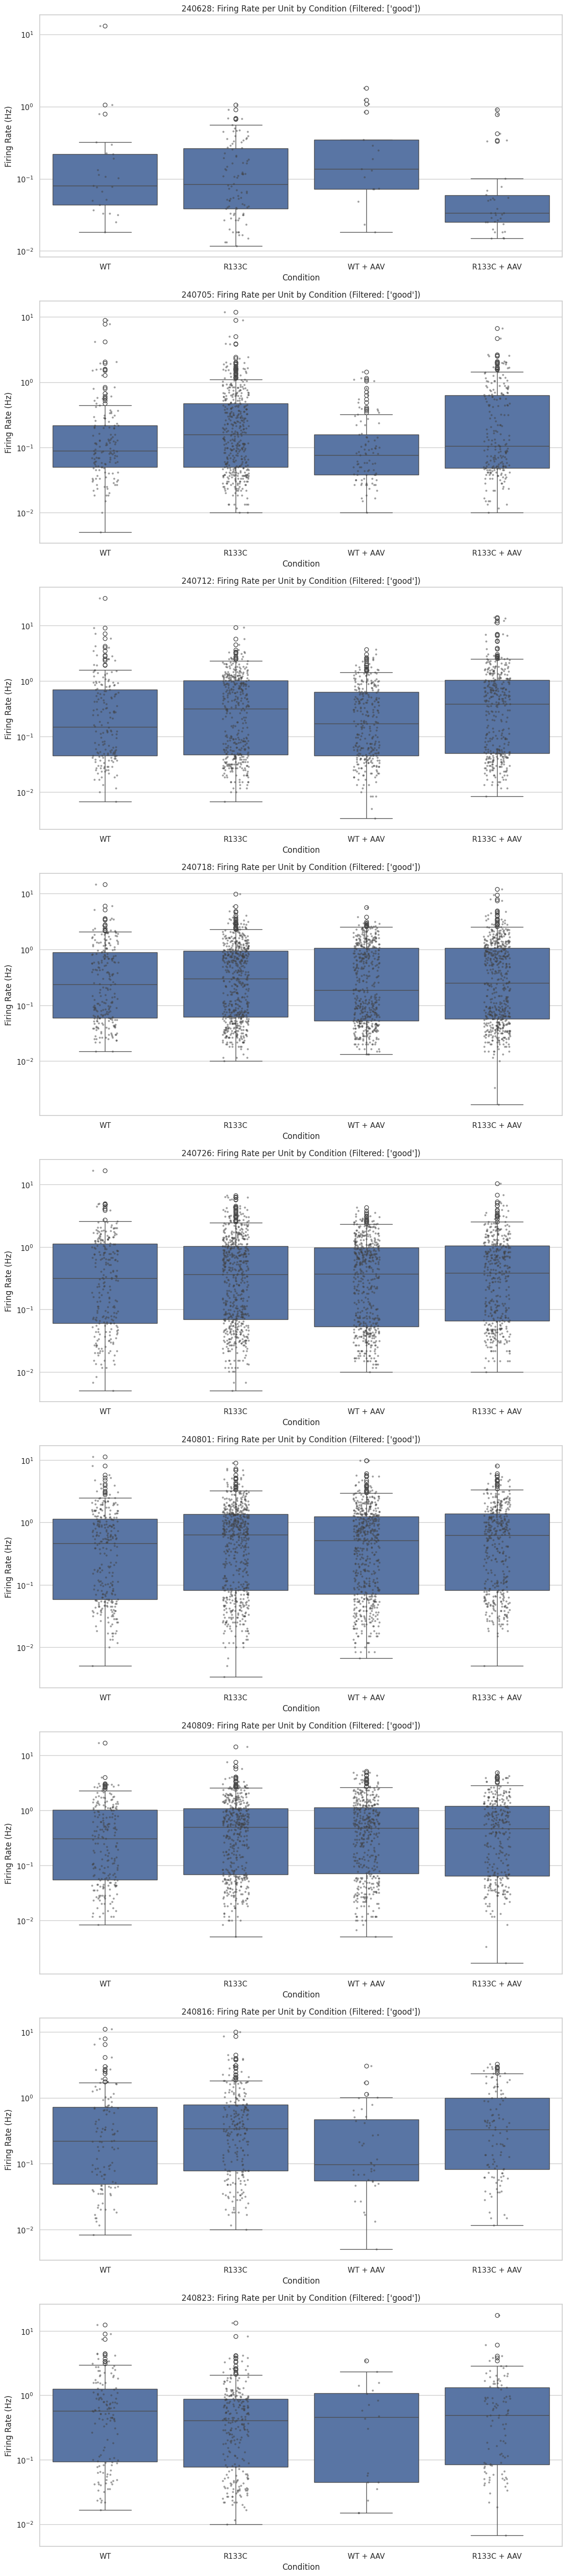

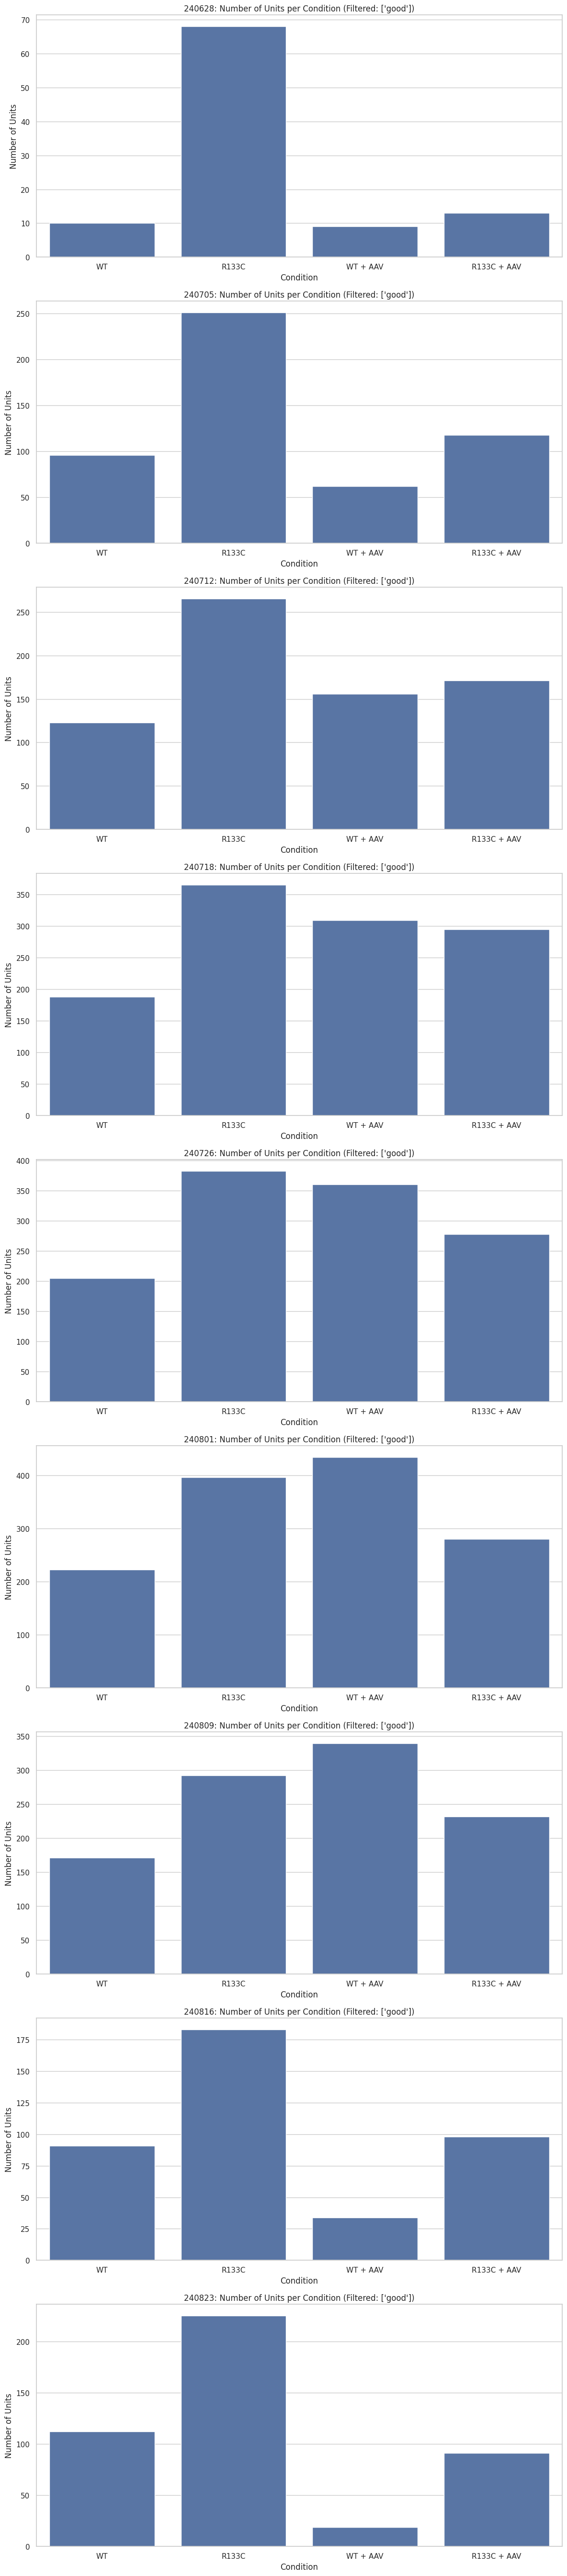

In [ ]:
# --- Visualization ---
print("\nGenerating plots...")
sns.set(style="whitegrid")
# Suppress UserWarnings from Seaborn/Matplotlib about figure layout
warnings.filterwarnings("ignore", category=UserWarning)



# Compare Conditions within each Week (Firing Rate)
plt.figure(figsize=(12, 6 * len(WEEKS)))
for i, week in enumerate(WEEKS):
    plt.subplot(len(WEEKS), 1, i + 1)
    week_data = unit_metrics[unit_metrics['week'] == week]
    if not week_data.empty:
            sns.boxplot(x='condition', y='firing_rate_hz', data=week_data, order=CONDITIONS)
            sns.stripplot(x='condition', y='firing_rate_hz', data=week_data, order=CONDITIONS, color=".25", size=3, alpha=0.5)
            plt.title(f'{week}: Firing Rate per Unit by Condition (Filtered: {QUALITY_FILTER})')
            plt.yscale('log')
            plt.ylabel("Firing Rate (Hz)")
            plt.xlabel("Condition")
            # Optional: Set y-limit if rates vary wildly
            # plt.ylim(0, week_data['firing_rate_hz'].quantile(0.95) * 1.1) # Example: limit to 95th percentile
    else:
            plt.text(0.5, 0.5, 'No data for this week', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title(f'{week}: No Data')
plt.tight_layout()
plt.show()



# Compare Conditions within each Week (Number of Units)
plt.figure(figsize=(12, 6 * len(WEEKS)))
for i, week in enumerate(WEEKS):
    plt.subplot(len(WEEKS), 1, i + 1)
    week_data = unit_metrics[unit_metrics['week'] == week]
    if not week_data.empty:
        # Count unique units per condition
        unit_counts = week_data.groupby('condition')['cluster_id'].nunique().reindex(CONDITIONS, fill_value=0)
        sns.barplot(x=unit_counts.index, y=unit_counts.values)
        plt.title(f'{week}: Number of Units per Condition (Filtered: {QUALITY_FILTER})')
        plt.ylabel("Number of Units")
        plt.xlabel("Condition")
    else:
            plt.text(0.5, 0.5, 'No data for this week', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title(f'{week}: No Data')
plt.tight_layout()
plt.show()
   

# --- End of Visualization ---
warnings.filterwarnings("default", category=UserWarning) # Restore warnings

## Visualization across weeks (grouped by cluster)

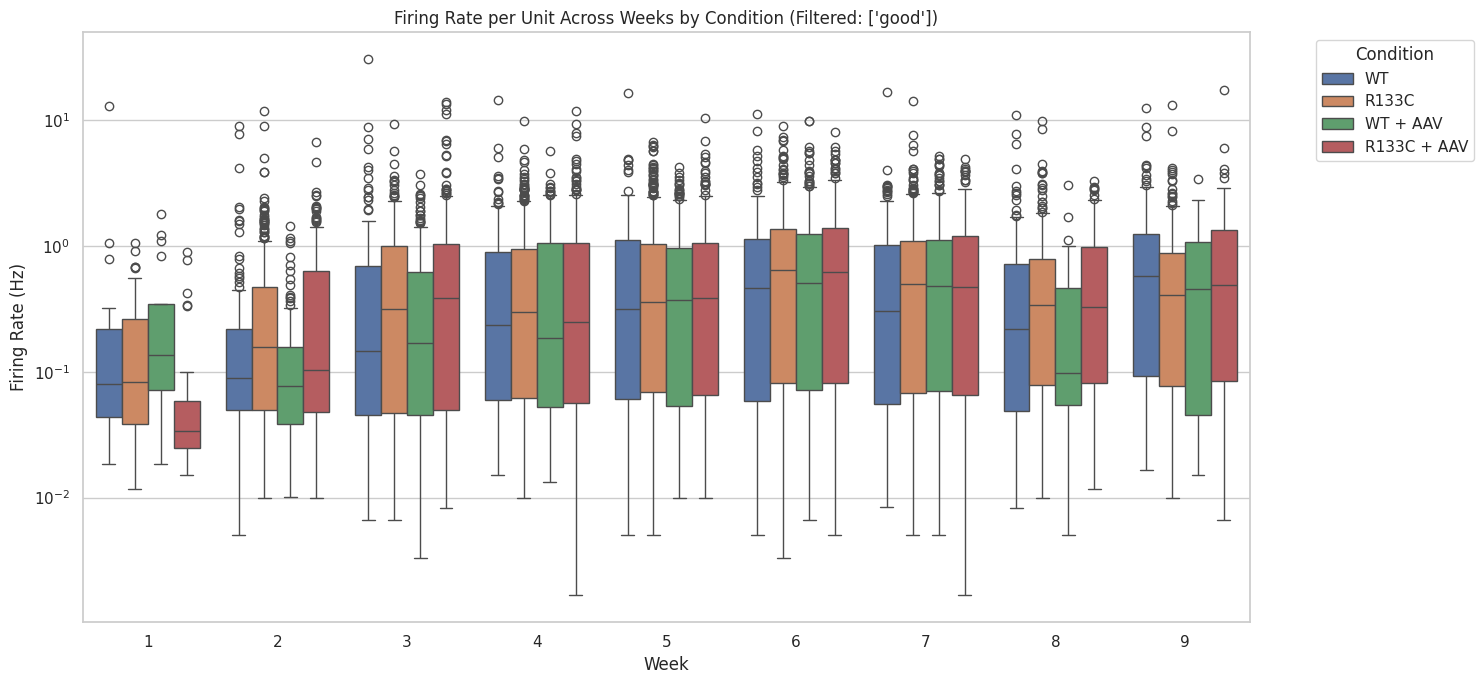

<Figure size 1200x600 with 0 Axes>

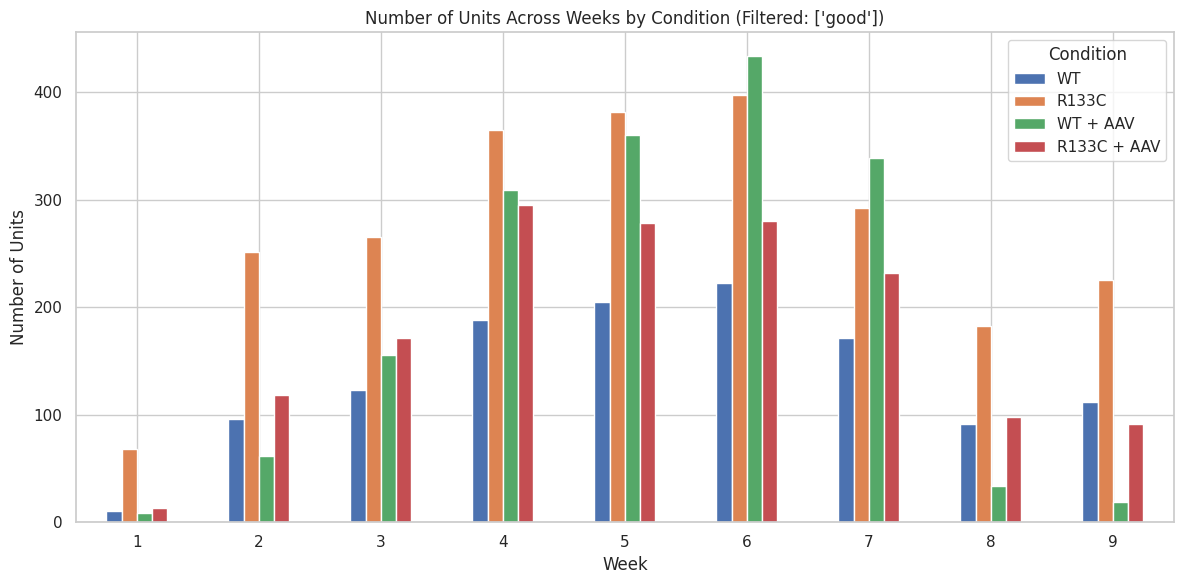


Mean amplitude plot skipped (no valid amplitude data found in metrics, check loading warnings).


In [ ]:
# Compare Firing Rates Across Weeks for each Condition
plt.figure(figsize=(15, 7))
if not unit_metrics.empty:
        sns.boxplot(x='week', y='firing_rate_hz', hue='condition', data=unit_metrics, 
                    order=WEEKS, hue_order=CONDITIONS)
        plt.title(f'Firing Rate per Unit Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
        plt.yscale('log')
        plt.ylabel("Firing Rate (Hz)")
        plt.xlabel("Week")
        plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
        # Optional: Add stripplot for individual points (can get crowded)
        # sns.stripplot(x='week', y='firing_rate_hz', hue='condition', data=unit_metrics, 
        #              order=WEEKS, hue_order=['Condition 1', 'Condition 2', 'Condition 3'],
        #              dodge=True, color=".25", size=2, alpha=0.3, legend=False)
else:
    plt.text(0.5, 0.5, 'No data available for plotting', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Firing Rate per Unit Across Weeks by Condition')
plt.tight_layout()
save_dir = FIGURE_DIR / "cluster_firing_rate.png"
plt.savefig(save_dir, dpi=300)
plt.show()



# Compare Number of Units Across Weeks for each Condition
plt.figure(figsize=(12, 6))
if not unit_metrics.empty:
    unit_counts_over_time = unit_metrics.groupby(['week', 'condition'])['cluster_id'].nunique().reset_index()
    # Pivot for plotting easily with seaborn barplot
    unit_counts_pivot = unit_counts_over_time.pivot(index='week', columns='condition', values='cluster_id').fillna(0)
    unit_counts_pivot = unit_counts_pivot.reindex(WEEKS).reindex(columns=CONDITIONS, fill_value=0) # Ensure correct order and fill missing weeks/conditions
    unit_counts_pivot.plot(kind='bar', figsize=(12, 6), rot=0) # Use pandas plotting directly or seaborn
    # Or using Seaborn directly (might need melted data):
    # sns.barplot(x='week', y='cluster_id', hue='condition', data=unit_counts_over_time,
    #              order=WEEKS, hue_order=['Condition 1', 'Condition 2', 'Condition 3'])
    
    plt.title(f'Number of Units Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
    plt.ylabel("Number of Units")
    plt.xlabel("Week")
    plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
    plt.legend(title='Condition')
else:
        plt.text(0.5, 0.5, 'No data available for plotting', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Number of Units Across Weeks by Condition')
plt.tight_layout()
save_dir = FIGURE_DIR / "cluster_number_units.png"
plt.savefig(save_dir, dpi=300)
plt.show()


# Optional: Compare Amplitudes (if available)
if 'amplitude' in unit_metrics.columns and not unit_metrics['mean_amplitude'].isnull().all():
        plt.figure(figsize=(15, 7))
        sns.boxplot(x='week', y='mean_amplitude', hue='condition', data=unit_metrics, 
                    order=WEEKS, hue_order=CONDITIONS)
        plt.title(f'Mean Spike Amplitude per Unit Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
        plt.yscale('log')
        plt.ylabel("Mean Amplitude (uV or raw units)") # Adjust label if you know the unit
        plt.xlabel("Week")
        plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        save_dir = FIGURE_DIR / "cluster_amplitudes.png"
        plt.savefig(save_dir, dpi=300)
        plt.show()
elif 'amplitude' in analysis_df.columns:
        print("\nMean amplitude plot skipped (no valid amplitude data found in metrics, check loading warnings).")
else:
        print("\nAmplitude plot skipped (amplitude data not loaded).")


# --- End of Visualization ---
warnings.filterwarnings("default", category=UserWarning) # Restore warnings

## Visualization across weeks (grouped by well)


Aggregating metrics per well...
Per-well metrics calculated.
     week     well condition  mean_firing_rate_hz  median_firing_rate_hz  \
0  240628  well000        WT             2.725086               0.190006   
1  240628  well001        WT             0.252292               0.106790   
2  240628  well003     R133C             0.112194               0.031737   
3  240628  well004     R133C             0.231659               0.213583   
4  240628  well005     R133C             0.198572               0.070020   

   num_units  
0          5  
1          5  
2          6  
3          6  
4         55  

Generating plots (with wells as data points)...


/tmp/ipykernel_2967315/3989944587.py:41: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='week', y='mean_firing_rate_hz', hue='condition',


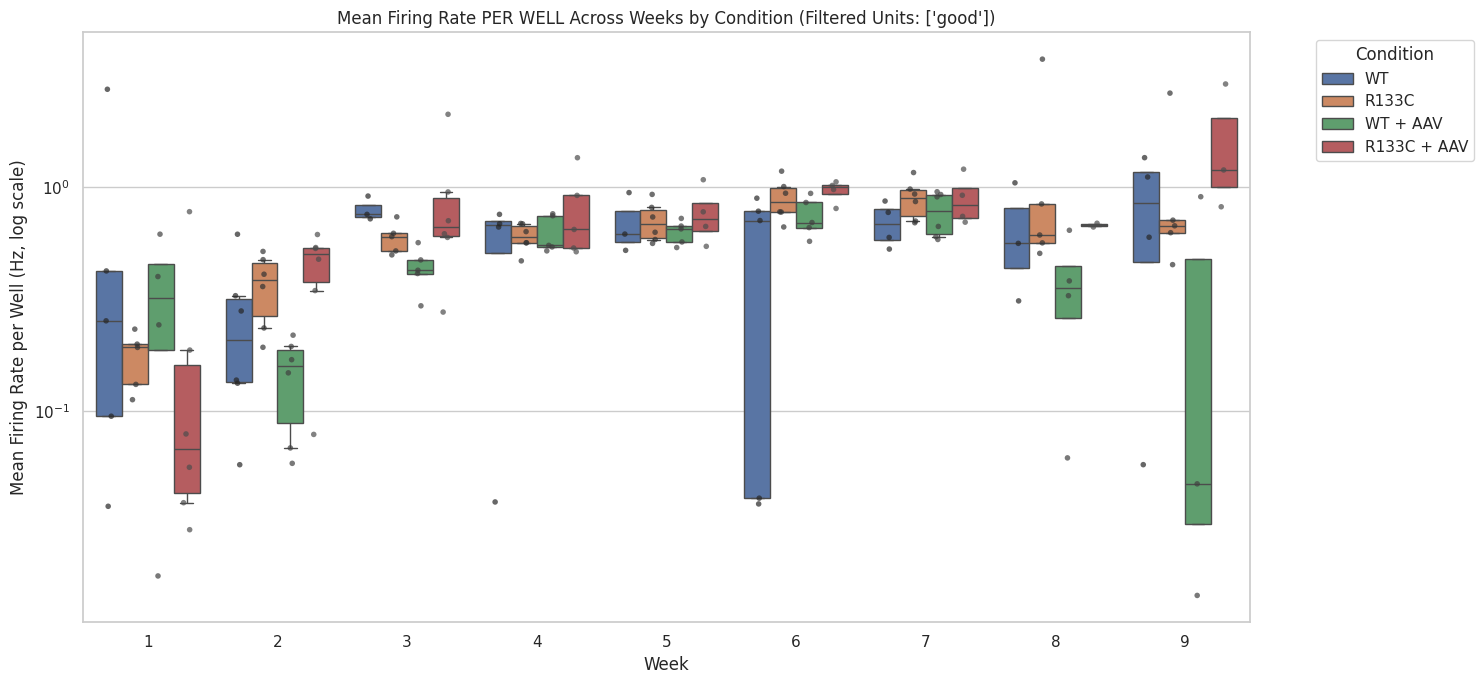

/tmp/ipykernel_2967315/3989944587.py:69: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='week', y='num_units', hue='condition',


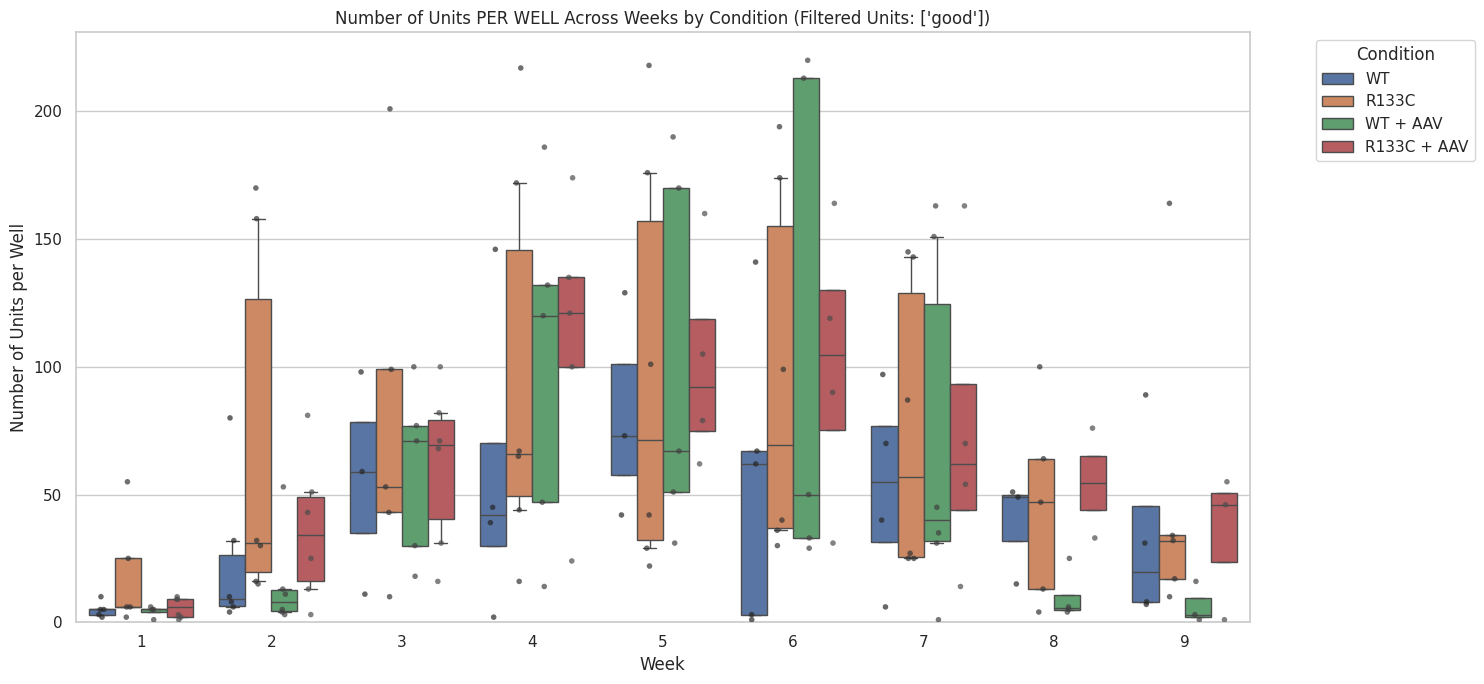

In [ ]:
# --- Aggregate Metrics per Well ---
# Calculate metrics where each data point represents a single well

print("\nAggregating metrics per well...")

# Group by week, well, and condition
well_metrics_grouped = unit_metrics.groupby(['week', 'well', 'condition'])

# Calculate desired metrics per well
well_metrics = well_metrics_grouped.agg(
    # Calculate mean firing rate of units within this well
    mean_firing_rate_hz=('firing_rate_hz', 'mean'),
    # Calculate median firing rate (alternative)
    median_firing_rate_hz=('firing_rate_hz', 'median'),
    # Count the number of unique units found in this well
    num_units=('cluster_id', 'nunique'),
    # Can add other metrics like mean amplitude per well if needed
    # mean_well_amplitude=('mean_amplitude', 'mean')
).reset_index() # Convert grouped object back to DataFrame

print("Per-well metrics calculated.")
print(well_metrics.head())




# --- Visualization (Modified for Per-Well Data Points) ---
print("\nGenerating plots (with wells as data points)...")
sns.set(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning) # Suppress layout warnings

# Compare Mean Firing Rates PER WELL Across Weeks for each Condition
plt.figure(figsize=(15, 7))
# Boxplot showing distribution of MEAN firing rates across WELLS
sns.boxplot(x='week', y='mean_firing_rate_hz', hue='condition', 
            data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
            whis=[5, 95], # Optional: Adjust whisker range if desired
            showfliers=False) # Optional: Hide outliers if stripplot is used
            
# Add stripplot to show individual WELL data points
sns.stripplot(x='week', y='mean_firing_rate_hz', hue='condition', 
                data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                dodge=True, color=".3", size=4, alpha=0.7, legend=False) # Removed legend=False only if boxplot handles it

plt.title(f'Mean Firing Rate PER WELL Across Weeks by Condition (Filtered Units: {QUALITY_FILTER})')
# Log scale might still be useful depending on the distribution of *mean* rates
plt.yscale('log')
plt.ylabel("Mean Firing Rate per Well (Hz, log scale)")
plt.xlabel("Week")
plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optional: Add horizontal lines for reference if needed
# plt.axhline(y=some_threshold, color='r', linestyle='--', linewidth=0.8)

plt.tight_layout()
save_dir = FIGURE_DIR / "intra_well_firing_rate.png"
plt.savefig(save_dir, dpi=300)
plt.show()


# Compare Number of Units PER WELL Across Weeks for each Condition
plt.figure(figsize=(15, 7)) # Adjusted size slightly
# Boxplot showing distribution of the NUMBER OF UNITS across WELLS
sns.boxplot(x='week', y='num_units', hue='condition', 
            data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
            whis=[5, 95], # Optional: Adjust whisker range
            showfliers=False) # Optional: Hide outliers if stripplot is used

# Add stripplot to show individual WELL data points
sns.stripplot(x='week', y='num_units', hue='condition', 
                data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                dodge=True, color=".3", size=4, alpha=0.7, legend=False) # Removed legend=False

plt.title(f'Number of Units PER WELL Across Weeks by Condition (Filtered Units: {QUALITY_FILTER})')
plt.ylabel("Number of Units per Well")
plt.xlabel("Week")
plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside

# Set y-axis to start from 0
plt.ylim(bottom=0) 


plt.tight_layout()
save_dir = FIGURE_DIR / "intra_well_number_units.png"
plt.savefig(save_dir, dpi=300)
plt.show()

## CV of the metrics

In [ ]:
# --- Calculate Intra-Well Coefficient of Variation (CV) ---

print("\nCalculating Intra-Well CV metrics...")

# Calculate CV of firing rate based on units WITHIN each well
if 'unit_metrics' in locals() and not unit_metrics.empty:
    # Group by well
    unit_grouped_by_well = unit_metrics.groupby(['week', 'well', 'condition'])

    # Calculate mean and std dev of firing rate WITHIN each well
    well_intrinsic_agg = unit_grouped_by_well['firing_rate_hz'].agg(['mean', 'std']).reset_index()

    # Calculate CV = std / mean for each well
    # Handle wells with 0 mean firing rate or only 1 unit (std=NaN)
    well_intrinsic_agg['cv_fr_per_well'] = np.where(
        (well_intrinsic_agg['mean'] != 0) & (well_intrinsic_agg['std'].notna()),
        well_intrinsic_agg['std'] / well_intrinsic_agg['mean'],
        np.nan # Assign NaN if mean is 0 or std is NaN (e.g., only 1 unit in well)
    )

    # Select relevant columns
    well_intrinsic_cv_metrics = well_intrinsic_agg[['week', 'well', 'condition', 'cv_fr_per_well']].copy()
    
    print("  Intra-Well CV metrics calculated.")
    # print(well_intrinsic_cv_metrics.head()) # Optional check
else:
    print("  Skipping Intra-Well CV calculation (unit_metrics missing or empty).")
    well_intrinsic_cv_metrics = pd.DataFrame(columns=['week', 'well', 'condition', 'cv_fr_per_well'])

print("-" * 20)


Calculating Intra-Well CV metrics...
  Intra-Well CV metrics calculated.
--------------------



Generating 'Distribution of Intra-Well Firing Rate CV' box plot...


/tmp/ipykernel_2967315/3994576645.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(


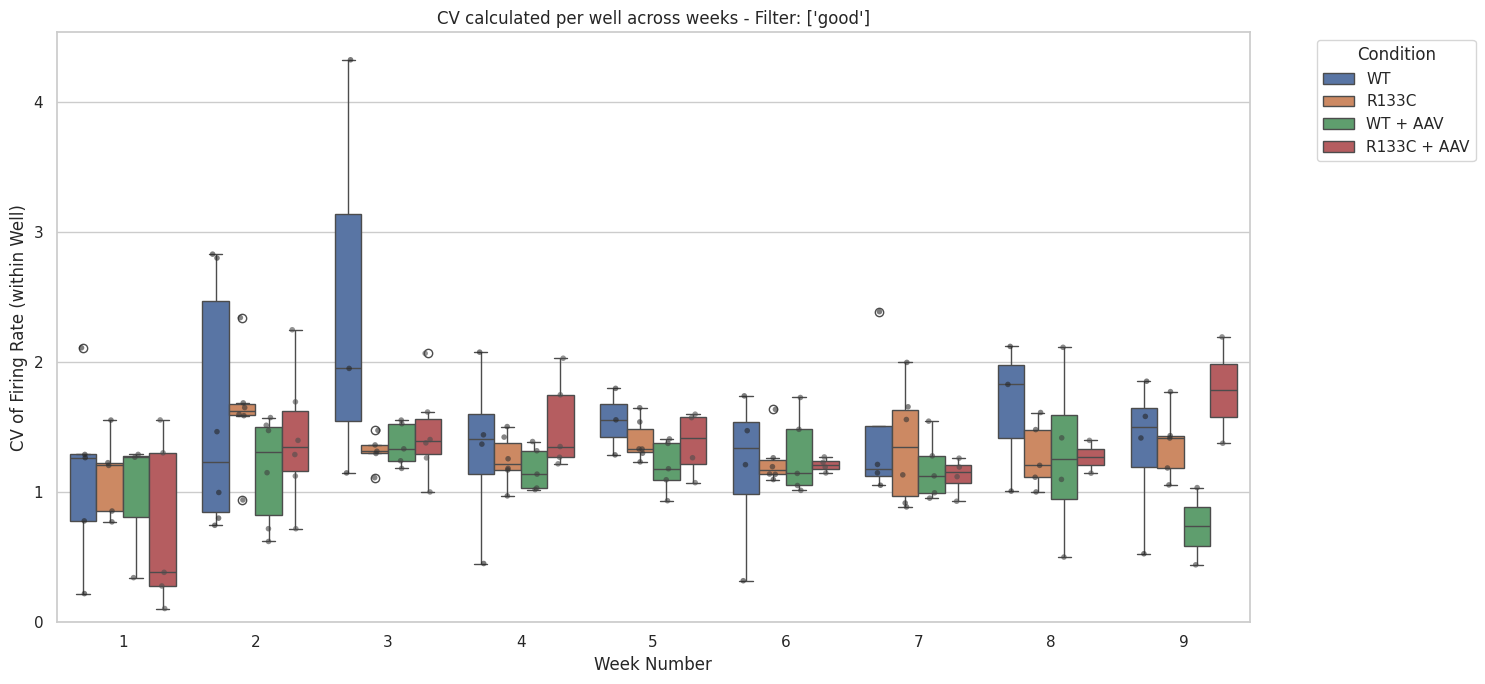

--------------------


<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Visualization ---

# *** ADD PLOT: Boxplot of Intra-Well Firing Rate CV Across Weeks ***
print("\nGenerating 'Distribution of Intra-Well Firing Rate CV' box plot...")

if not well_intrinsic_cv_metrics.empty:

    fig_cv_well_fr = plt.figure(figsize=(15, 7)) # Capture figure handle

    # Create the boxplot - Use 'week_number' for x and the numeric order
    ax_cv_wfr = sns.boxplot(
        data=well_intrinsic_cv_metrics,
        x='week', # Use the new numerical column
        y='cv_fr_per_well',
        hue='condition',
        order=WEEKS, # Use the numeric order
        hue_order=CONDITIONS,
        showfliers=True
    )

    # Optional: Overlay stripplot - Use 'week_number' for x
    sns.stripplot(
        data=well_intrinsic_cv_metrics,
        x='week', # Use the new numerical column
        y='cv_fr_per_well',
        hue='condition',
        order=WEEKS, # Use the numeric order
        hue_order=CONDITIONS,
        dodge=True,
        color=".3",
        size=4,
        alpha=0.6,
        legend=False,
        ax=ax_cv_wfr
    )

    ax_cv_wfr.set_title(f'CV calculated per well across weeks - Filter: {QUALITY_FILTER}')
    ax_cv_wfr.set_ylabel("CV of Firing Rate (within Well)")
    ax_cv_wfr.set_xlabel("Week Number") # Update label
    ax_cv_wfr.set_xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
    ax_cv_wfr.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_cv_wfr.set_ylim(bottom=0)

    # Seaborn should automatically use the numbers 1, 2, 3... as ticks now.
    # If you need explicit control (less common with numeric data):
    # ax_cv_wfr.set_xticks(range(len(WEEKS_numeric_order))) # Set tick positions 0, 1, 2...
    # ax_cv_wfr.set_xticklabels(WEEKS_numeric_order) # Set tick labels 1, 2, 3...

else:
    fig_cv_well_fr = plt.figure(figsize=(15, 7)) # Still need figure if empty
    plt.text(0.5, 0.5, 'No Intra-Well CV data available for plotting',
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Distribution of Intra-Well Firing Rate CV Across Weeks')
    plt.xlabel("Week") # Update label even for empty plot

plt.tight_layout()
plt.show()
save_dir = FIGURE_DIR / "intra_well_firing_rate_cv.png"
plt.savefig(save_dir, dpi=300)
plt.close(fig_cv_well_fr)